In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#import theano
#import keras.backend as K
%matplotlib inline

from test_saliency.utils import decode, ssConvertMap, aaString_Fang, aaMap_fang, convertPredictQ8Result2HumanReadable, window
from test_saliency.data_managing import load_data

In [67]:
import test_saliency.utils as ts
reload(ts)

<module 'test_saliency.utils' from 'test_saliency/utils.py'>

## Loading model

In [6]:
from keras.models import load_model
model = load_model("StandAlone/data/modelQ8.h5")

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/juillermo/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Visualize model

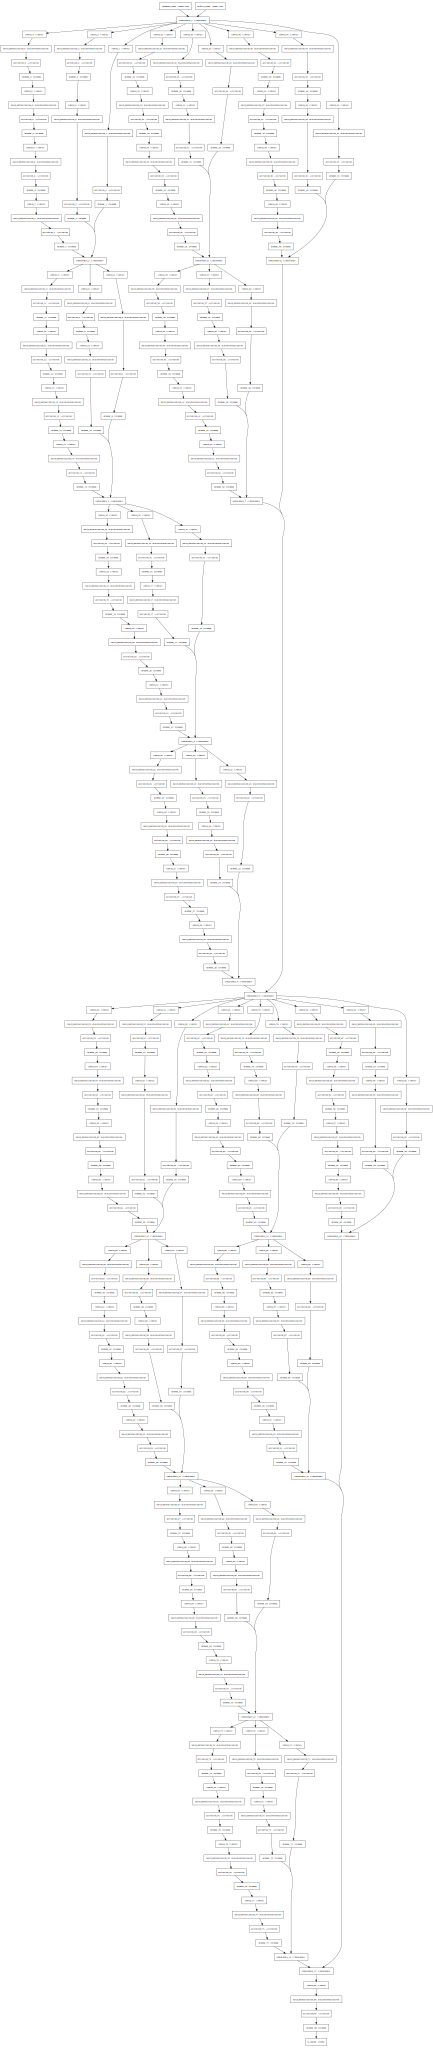

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png')

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 700, 21)      0                                            
__________________________________________________________________________________________________
profile_input (InputLayer)      (None, 700, 21)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 700, 42)      0           sequence_input[0][0]             
                                                                 profile_input[0][0]              
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 700, 100)     4300        concatenate_1[0][0]              
__________

In [9]:
output = model.get_layer(index=-1)
o_weights = output.get_weights()
print(o_weights[0].shape)
print(o_weights[1].shape)

(455, 9)
(9,)


In [24]:
print type(model.outputs[0])
print model.outputs[0].shape

theano.tensor.var.TensorVariable

In [36]:
conv1d = model.get_layer(index=3)
conv1d.get_config()

{'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1,),
 'filters': 100,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': u'uniform',
   'mode': u'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (1,),
 'name': u'conv1d_4',
 'padding': u'same',
 'strides': (1,),
 'trainable': True,
 'use_bias': True}

-------------------------

## Loading data

In [2]:
num_seqs = 0#4
X_am, X_pssm, mask, labels = load_data("test_saliency/", num_seqs)

------------------------- 

## Analyze performance

### Spot best predictors

In [3]:
with open("test_saliency/predictions.pkl", 'rb') as f:
    predictions = pickle.load(f)
print predictions.shape

(6048, 700, 9)


In [146]:
for target_class in range(8):
    print "Class ", ssConvertMap[target_class]

    max_target = np.argmax( predictions[:, :, target_class] )
    max_target = np.unravel_index( max_target, predictions.shape[0:2] )
    seq = max_target[0]
    pos = max_target[1]
    
    print "max_target", max_target
    print "value: ", predictions[seq, pos, target_class]

    if pos >= window:
        init = pos - window
    else:
        init = 0
    end = pos + window + 1
    
    gato = decode( X_am[seq] )
    print "Aminoacids ", gato[ init:pos ], gato[ pos ], gato[ pos+1:end ]
    perro = convertPredictQ8Result2HumanReadable( predictions[seq] )
    print "Predictions", perro[init:pos], perro[pos], perro[pos+1:end]
    conejo = "".join([ssConvertMap[el] for el in labels[seq]])
    print "True labels", conejo[init:pos], conejo[pos], conejo[pos+1:end], "\n"
    
    #gradients = theano.gradient.grad(model.outputs[0][seq,pos,target_class], wrt=[model.inputs[0], model.inputs[1]])
    #get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)
    #inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
    #inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
    #grads = get_gradients(inputs)
    #grads = np.array(grads)
    #plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance

Class  C
max_target (546, 0)
value:  0.9999999
Aminoacids   E ADQVIENLQRNELTPREIADFIGRELAKG
Predictions  C CCCCCCHHHHHHHHHHHCCSSCEECHHHH
True labels  C CHHHHHHHHTTCCCHHHHHHHHHHHHHTT 

Class  B
max_target (1081, 59)
value:  0.99818134
Aminoacids  GGQDDEMMVKVASTKVTVSESDAAKKLQE F ITFEKGIDGPFTSKNAAAAAAAAAAAAAA
Predictions EEEECTGGEEEEECHGGHTTSCTGHGTTS B HHHHCGGGTTHHHHHHHHHHHHHCCCEEE
True labels CSSGGGGEEEEEEEEECCCCHHHHHHHHH H HTTCCCCSSSCCCCCCCCCCCCCCCCCCC 

Class  E
max_target (4283, 73)
value:  0.99999964
Aminoacids  LDTLEDDMTISVEKKVPLLHNFHSFLYQP D WRFMESKEKDRQVLEDFPTISLEFRNLAE
Predictions CECSHHHHHHHHHHHHHHHHHHHHTTCSE E EECSTTCHHHHHHHHHCSSCEEEEHHHHH
True labels HHHHHHCTTSCHHHHHHHHHHHHHHTTCT T CCCCCCCSTTTHHHHTHHHHHHHHHTSCH 

Class  G
max_target (3743, 75)
value:  0.999408
Aminoacids  FLKDVGIEDNQLGAFLTKNHAIFSEDLEN L KTRVAYLHSKNFSKADVAQMVRKAPFLLN
Predictions TGGGCEECCCTTHHHHHHHHHHHHTCCGG G EEEESSHHHHHHHHHHHHCCSEEEEEESC
True labels HHHHHTCCGGGHHHHHHHCTTGGGSCHHH H HHHHHHHHHTTCCHHHHHHHHHHSTTGG

In [147]:
sum(mask[5404])

86.0

### Evaluate saliencies

**Aggregate saliencies**

In [28]:
target_class = "H"
num_seqs = 4
saliencies = np.zeros((2,700,num_seqs,700,21))
for seq in range(num_seqs):
    with open("test_saliency/saliencies/saliencies"+str(seq)+target_class+".pkl", "rb") as f:
        temp = np.array(pickle.load(f))
        saliencies[:,:,seq,:,:] = temp[:,:,0,:,:]
print("Saliencies shape", saliencies.shape)

('Saliencies shape', (2, 700, 4, 700, 21))


**Inspect sequential saliency**

In [87]:
X_am.shape

(6044, 700, 21)

In [91]:
sorted_fang = sorted(aaMap_fang.keys(), key=lambda letter: aaMap_fang[letter])

aaMap = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X']
pssm = 'ACDEFGHIKLMNPQRSTVWXY'
aaMap_jurtz = {amino: i for i, amino in enumerate(aaMap)}
pssm_jurtz = {amino: i for i, amino in enumerate(pssm)}

index_am = np.array([aaMap_jurtz[letter] for letter in sorted_fang if letter is not 'NoSeq'])
index_pssm = np.array([pssm_jurtz[letter] for letter in sorted_fang if letter is not 'NoSeq'])

aaMap_fang['X']
print len(aaMap)
print len(index_am), len(index_pssm)
print index_am

KeyError: 'X'

In [88]:
pos = 0

print X_am[seq,pos]
print len(X_am[seq,pos])

dc = decode(X_am[seq,:end])
print len(dc)
print dc[pos]
print dc

182
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
21
AEICLITGTPGSGKTLKVSANDEFKPDENGIRRKVFTNIKGLKIPHTYIETDAKKLPKSTDEQLSAHDYEWIKKPENIGSIVIVDEAQDVWPARSAGSKIPENVQWLNTHRHQGIDIFVLTQGPKLLDQNLRTLVRKHYHIASNKGRTLLEWKICADDPVKASSAFSSIYTLDKKVYDLYES
A


'perro'

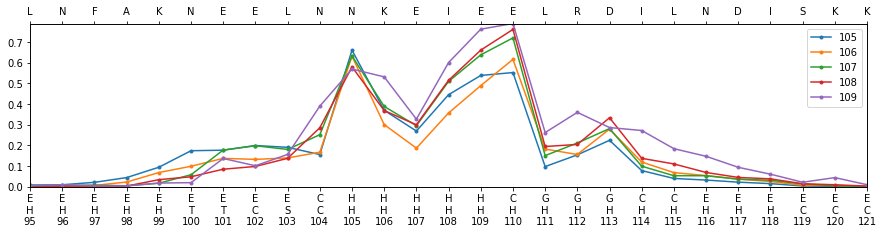

In [171]:
seq = 0
final_pos = 150
window = 29

end = final_pos + window + 1
end_seq = int(sum(mask[seq]))
if end > end_seq:
    end = end_seq
if final_pos > end_seq:
    final_pos = end_seq

preds = convertPredictQ8Result2HumanReadable( predictions[seq] )
    
fig, ax = plt.subplots(figsize=(15,3))
for pos in range(final_pos):
    if preds[pos] == 'H':
    #if ssConvertMap[labels[seq,pos]] == 'H':        
        temp = np.einsum('ij,ij->i', abs(saliencies[0,pos,seq,95:end,:]), X_am[seq,95:end])
        temp += np.einsum('ij,ij->i', abs(saliencies[1,pos,seq,95:end,:]), X_pssm[seq,95:end])
        ax.plot(temp, marker='.', label=str(pos))
        #ax.plot(np.sum(np.sum(abs(saliencies[:,pos,seq,:end,:]), axis=2), axis=0), marker='.') # Aminoacid importance

ax.xaxis.set(ticks=range(end), ticklabels=[preds[95+i]+"\n"+ssConvertMap[el]+"\n"+str(95+i) for i, el in enumerate(labels[seq,95:end])])
ax.margins(0)
ax.legend()
ax2 = ax.twiny()
ax2.xaxis.set(ticks=range(end-95), ticklabels=decode(X_am[seq,95:end]))
"perro"

In [169]:
len(decode(X_am[seq,95:end]))

27

-27

In [140]:
np.multiply(saliencies[0,pos,seq,init:pos,:], X_am[seq,init:pos]).shape

(29, 21)

In [142]:
total[:, :window].shape

(2, 29, 21)

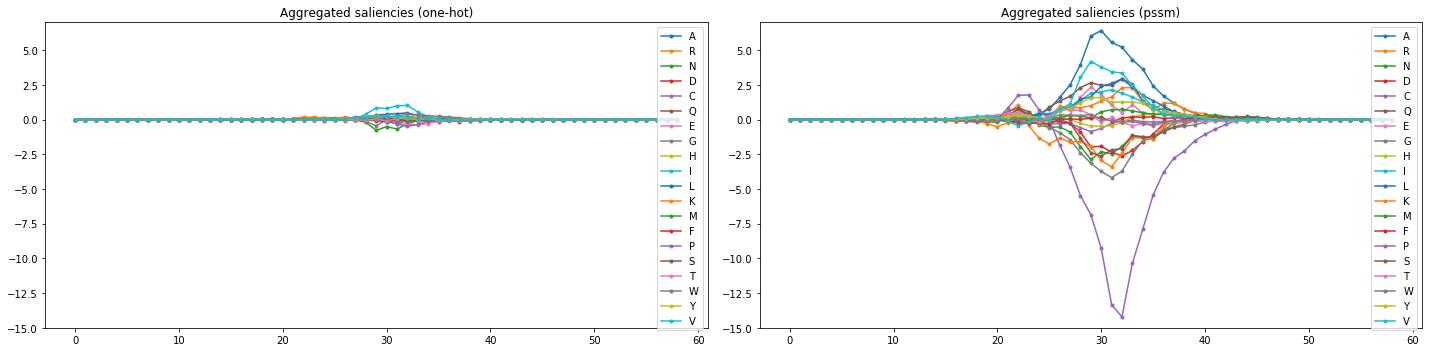

In [178]:
total = np.zeros((2, 2*window + 1, 21)) # one-hot/pssm, window-size, n aminoacids
for seq in range(len(saliencies)):
    end_seq = int(sum(mask[seq]))
    for pos in range(end_seq):
        # Pre-window
        if pos > window:
            init = pos - window
            #total[:, :window] += saliencies[:,pos,seq,init:pos,:]
            total[0, :window] += np.multiply(saliencies[0,pos,seq,init:pos,:], X_am[seq,init:pos])
            total[1, :window] += np.multiply(saliencies[1,pos,seq,init:pos,:], X_pssm[seq,init:pos])
        elif pos != 0:
            init = window - pos
            #total[:, init:window] += saliencies[:,pos,seq,0:pos,:]
            total[0, init:window] += np.multiply(saliencies[0,pos,seq,0:pos,:], X_am[seq,0:pos])
            total[1, init:window] += np.multiply(saliencies[1,pos,seq,0:pos,:], X_pssm[seq,0:pos])
        
        # Window
        #total[:, window] = saliencies[:,pos,seq,pos,:]
        total[0, window] += np.multiply(saliencies[0,pos,seq,pos,:], X_am[seq,pos])
        total[1, window] += np.multiply(saliencies[1,pos,seq,pos,:], X_pssm[seq,pos])

        # Post-window
        if pos + window + 1 <= end_seq:
            end = pos + window + 1
            #total[:, window+1:] = saliencies[:,pos,seq,pos+1:end,:]
            total[0, window+1:] += np.multiply(saliencies[0,pos,seq,pos+1:end,:], X_am[seq,pos+1:end])
            total[1, window+1:] += np.multiply(saliencies[1,pos,seq,pos+1:end,:], X_pssm[seq,pos+1:end])
        elif pos != end_seq:
            end = end_seq
            #total[:, window+1:-(pos+window+1-end)] = saliencies[:,pos,seq,pos+1:end,:]
            total[0, window+1:-(pos+window+1-end)] += np.multiply(saliencies[0,pos,seq,pos+1:end,:], X_am[seq,pos+1:end])
            total[1, window+1:-(pos+window+1-end)] += np.multiply(saliencies[1,pos,seq,pos+1:end,:], X_pssm[seq,pos+1:end])

def plot1(total, aaString_Fang):
    fig, ax = plt.subplots(figsize=(20,5))
    for el in range(21):
        #ax.plot(np.sum(abs(total[:,:,el]), axis=0), label=aaString_Fang[el])
        ax.plot(np.sum(total[:,:,el], axis=0), label=aaString_Fang[el])
    ax.legend()
        

def plot2(total, aaString_Fang):
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    ax = axes[0]
    ax1 = axes[1]
    for el in range(20):
        ax.plot(total[0,:,el], label=aaString_Fang[el], marker='.')
        ax1.plot(total[1,:,el], label=aaString_Fang[el], marker='.')
    ax.legend()
    ax.set(ylim= [-15, 7], title="Aggregated saliencies (one-hot)")
    ax1.legend()
    ax1.set(ylim= [-15, 7], title="Aggregated saliencies (pssm)")
    plt.tight_layout()
    
#plot1(total, aaString_Fang)
plot2(total, aaString_Fang)

In [135]:
total.shape

(2, 59, 21)

In [179]:
tomotif = np.sum(total, axis=0)
for row in range(len(tomotif)):
    print " ".join("{:.8f}".format(el) for el in tomotif[row])

-0.00000000 -0.00000000 0.00000000 -0.00000000 0.00000000 -0.00000000 -0.00000000 -0.00000000 0.00000000 -0.00000000 0.00000000 -0.00000000 0.00000000 0.00000000 -0.00000000 0.00000000 0.00000000 -0.00000000 0.00000000 0.00000000 -0.00000000
0.00000000 -0.00000006 0.00000000 -0.00000001 -0.00000000 -0.00000002 -0.00000001 -0.00000002 0.00000002 -0.00000001 0.00000001 -0.00000007 0.00000002 0.00000001 -0.00000002 0.00000001 0.00000001 -0.00000002 0.00000001 0.00000001 -0.00000003
0.00000003 -0.00000029 0.00000002 -0.00000008 -0.00000005 -0.00000006 0.00000003 -0.00000009 0.00000020 -0.00000010 0.00000008 -0.00000043 0.00000016 0.00000002 -0.00000015 0.00000011 0.00000014 -0.00000017 0.00000014 0.00000004 -0.00000003
0.00000045 -0.00000082 0.00000021 -0.00000002 -0.00000034 0.00000006 0.00000026 -0.00000056 0.00000029 0.00000047 0.00000075 -0.00000148 0.00000100 -0.00000041 -0.00000066 0.00000042 0.00000046 -0.00000058 0.00000098 -0.00000055 0.00000031
0.00000407 -0.00001108 -0.00000063 

In [105]:
np.max(tomotif)

13.23676788184844

**Gradient computation drafts**

In [53]:
#weights = model.trainable_weights # weight tensors
gradients = theano.gradient.grad(model.outputs[0][seq,pos,7], wrt=[model.inputs[0], model.inputs[1]])
gradients = theano.gradient.jacobian(model.outputs[0][seq,pos,5].flatten(), wrt=[model.inputs[0], model.inputs[1]])
#gradients = K.gradients(model.predict, model.inputs)
#gradients = K.gradients(model.total_loss, model.inputs) # gradient tensors
#input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
#get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [106]:
get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)

In [109]:
inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
grads = get_gradients(inputs)
grads = np.array(grads)

(2, 1, 700, 21)

In [94]:
grads[:,seq,init:end,:]

array([[[-1.30143346e-12, -8.42253264e-12, -1.02235729e-11, ...,
         -4.55312264e-12,  3.60481393e-12,  1.45631705e-12],
        [ 8.03531408e-11, -1.39723259e-12,  5.40718893e-11, ...,
          7.32759756e-11,  3.53763997e-11, -6.99510762e-12],
        [-1.08706572e-10, -1.86981541e-10, -3.23495813e-10, ...,
         -3.27680272e-10,  1.90031033e-10,  6.79268100e-11],
        ...,
        [ 2.25766129e-13, -5.01347390e-13,  5.91065608e-13, ...,
          2.65183654e-13, -2.47494083e-14, -2.01070199e-13],
        [ 5.14729149e-14,  9.01710686e-14,  1.03888347e-13, ...,
          1.73511243e-14, -4.54712290e-14, -8.17424199e-14],
        [ 6.72787047e-15, -6.02380482e-15,  1.18631343e-14, ...,
          6.08384802e-15,  2.71091116e-15,  9.20786139e-15]],

       [[ 1.54587725e-12,  3.38451923e-12,  8.48274055e-12, ...,
         -1.50026415e-11, -3.45101660e-12, -8.26000780e-14],
        [ 2.44336253e-11, -1.18907606e-10,  8.05771075e-12, ...,
          6.94067156e-12,  6.10600320e

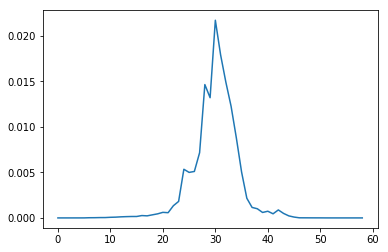

In [127]:
plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance
#plt.plot(grads[1,0,pos,:])

In [123]:
abs(grads[:,seq,init:end,:]).shape

(2, 59, 21)

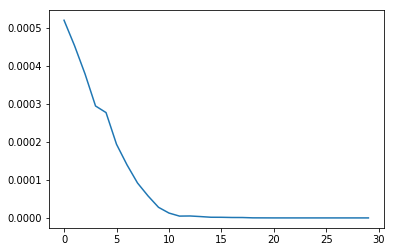

In [11]:
plt.plot(saliencies[0,0]["grads"])

------------------------------------------------

## Analyze sequence predictions

In [4]:
with open("test_saliency/predictions.pkl", "rb") as f:
    predictions = pickle.load(f)
    print("Predictions shape", predictions.shape)

In [56]:
from test_saliency.saliency import load_data
split_value = 5534

X_am, X_pssm, mask, labels = load_data("test_saliency/")
print("X_am shape", X_am.shape, "X_pssm shape", X_pssm.shape, "mask shape", mask.shape, "labels shape",labels.shape)

Using Theano backend.


('X_am shape', (6048, 700, 21), 'X_pssm shape', (6048, 700, 21), 'mask shape', (6048, 700), 'labels shape', (6048, 700))


In [7]:
def calculate_seq_accuracy(predictions, labels):
    num_seq = len(mask)
    seq_len = predictions.shape[1]

    seq_acc = np.zeros(num_seq)
    for seq in range(num_seq):
        for pos in range(seq_len):
            if mask[seq,pos]:
                if labels[seq, pos] == np.argmax(predictions[seq, pos]):
                    seq_acc[seq] += 1
            else:
                break

        seq_acc[seq] /= np.sum(mask[seq])
    
    return seq_acc

In [8]:
seq_acc = calculate_seq_accuracy(predictions, labels)
split_value = 5534
seq_acc_train = seq_acc[:split_value]
seq_acc_test = seq_acc[split_value:]

### Per-sequence accuracy plots

In [32]:
def print_sorted_seqs(seqs, ax, label):
    ax.plot(sorted(seqs), marker="X", linewidth=0)
    ax.set(title='Per-sequence accuracy ('+label+')', ylim=[0, 1])

In [20]:
lengths_train = np.sum(mask[:split_value], axis=1)
lengths_test = np.sum(mask[split_value:], axis=1)
print len(lengths_train[lengths_train > 300])
print len(lengths_test[lengths_test > 300])

1210
59


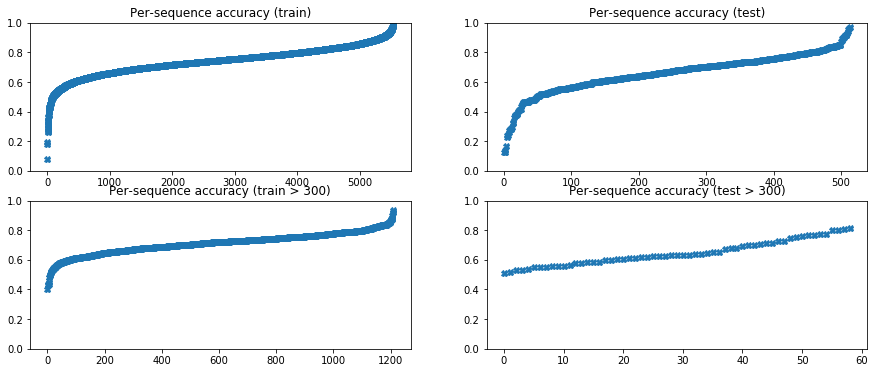

In [38]:
fig,ax = plt.subplots(2,2, figsize=(15,6))

print_sorted_seqs(seq_acc_train, ax[0][0], "train")
print_sorted_seqs(seq_acc_test, ax[0][1], "test")

print_sorted_seqs(seq_acc_train[lengths_train > 300], ax[1][0], 'train > 300')
print_sorted_seqs(seq_acc_test[lengths_test > 300], ax[1][1], 'test > 300')

### Accuracy-size plots

In [51]:
def print_length_vs_acc(lengths, seqs, ax, label):
    seq_len = 700
    
    ax.plot(lengths, seqs, marker="X", linewidth=0, label="sequences")
    ax.plot(np.mean(seqs)*np.ones(seq_len), label="mean")
    ax.set(title='Per-sequence accuracy ('+label+')',
           ylabel="accuracy", xlabel="sequence length", ylim=[0, 1])
    ax.legend()

5534 5534
514 514
1210 1210
59 59


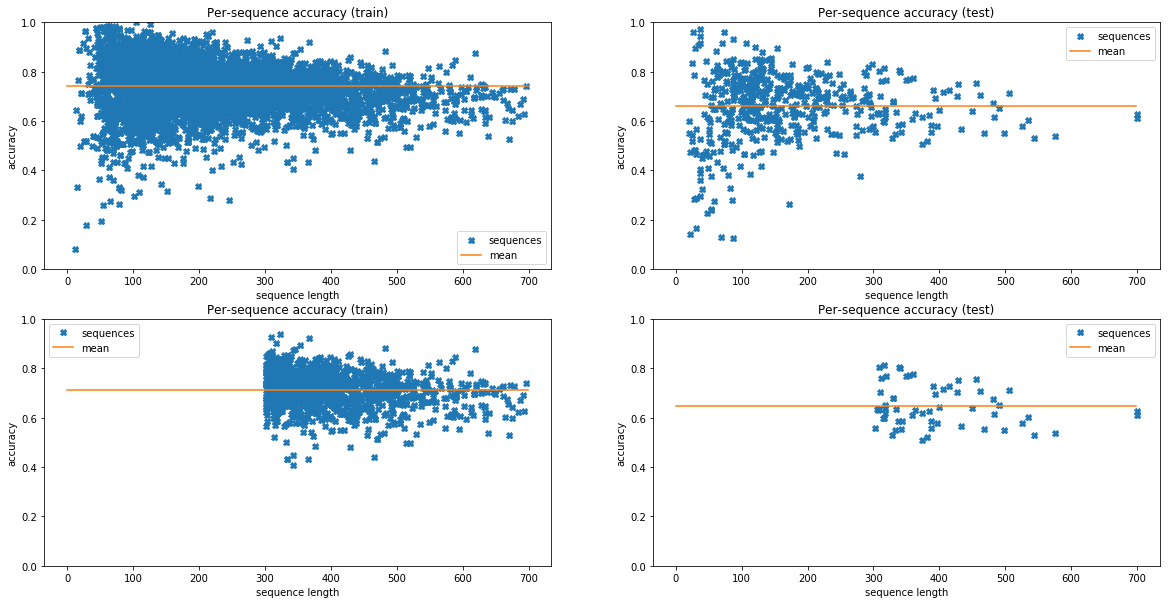

In [58]:
fig,ax = plt.subplots(2,2, figsize=(20,10))

print_length_vs_acc(lengths_train, seq_acc_train, ax[0][0], 'train')
print_length_vs_acc(lengths_test, seq_acc_test, ax[0][1], 'test')

print_length_vs_acc(lengths_train[lengths_train > 300], seq_acc_train[lengths_train > 300], ax[1][0], 'train')
print_length_vs_acc(lengths_test[lengths_test > 300], seq_acc_test[lengths_test > 300], ax[1][1], 'test')